<ipython-input-16-a7cfba953bd9>:35: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


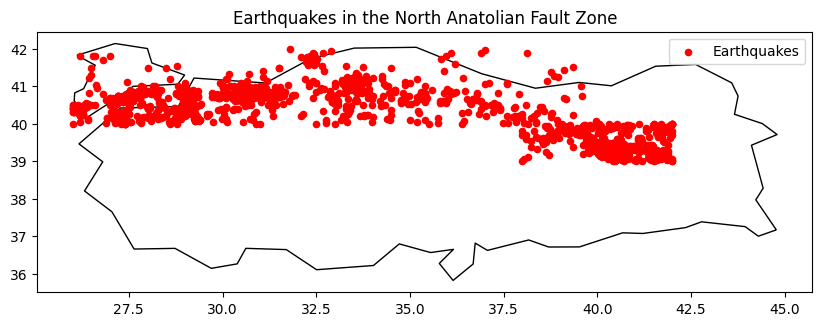

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Load your dataset
df = pd.read_csv('/content/AFAD_1900_today_31461754_4_9.csv')

# Filter for the North Anatolian Fault Zone
min_longitude = 26
max_longitude = 40
min_latitude = 40
max_latitude = 42

second_min_longitude = 38
second_max_longitude = 42
second_min_latitude = 39
second_max_latitude = 40

fault_zone_earthquakes = df[(df['Longitude'] >= min_longitude) & (df['Longitude'] <= max_longitude) &
                            (df['Latitude'] >= min_latitude) & (df['Latitude'] <= max_latitude)]

additional_region_earthquakes = df[(df['Longitude'] >= second_min_longitude) & (df['Longitude'] <= second_max_longitude) &
                                   (df['Latitude'] >= second_min_latitude) & (df['Latitude'] <= second_max_latitude)]

# Combine the two datasets
combined_earthquakes = pd.concat([fault_zone_earthquakes, additional_region_earthquakes])
combined_earthquakes = combined_earthquakes.drop_duplicates()

# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(combined_earthquakes['Longitude'], combined_earthquakes['Latitude'])]
geo_df = gpd.GeoDataFrame(combined_earthquakes, geometry=geometry)

# Load map of Turkey
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
turkey = world[world.name == "Turkey"]

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
turkey.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, markersize=20, color='red', marker='o', label='Earthquakes')
plt.title('Earthquakes in the North Anatolian Fault Zone')
plt.legend()
plt.show()


In [62]:
combined_earthquakes.head()

,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,MagnitudeName,Previous_Magnitude
1037,01/01/1986 08:09:08,41.8230,39.1210,35.00,mb,4.8,-,9729,ISC,ISC,ISC,4.8
1422,01/01/1988 14:21:51,29.2320,40.1365,6.40,mb,4.5,-,10114,ISC,ISC,ISC,4.8
14134,01/01/2016 11:11:14,30.5338,40.0415,7.38,Mw,4.0,Mihalgazi (Eskişehir),322365,AFAD,AFAD,AFAD,4.5
13695,01/01/2019 05:09:34,40.4995,39.4006,11.68,Mw,4.2,Yedisu (Bingöl),428352,AFAD,AFAD,AFAD,4.0
506,01/02/1940 07:12:56,33.0000,41.0000,30.00,MS,4.9,-,8821,Ayhan ve Diğ.1981,Ayhan ve Diğ.1981,Ayhan ve Diğ.1981,4.2


# **Data Preperation**

In [56]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Create 'Previous_Magnitude' column
combined_earthquakes['Previous_Magnitude'] = combined_earthquakes['Magnitude'].shift(1)
combined_earthquakes['Previous_Magnitude'].fillna(method='bfill', inplace=True)

# Define feature and target columns
features = combined_earthquakes[['Longitude', 'Latitude', 'Depth', 'Previous_Magnitude']]
targets = combined_earthquakes[['Longitude', 'Latitude', 'Magnitude']]

# Normalize features and targets
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_targets = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler_features.fit_transform(features)
targets_scaled = scaler_targets.fit_transform(targets)

# Split data into train and test sets
split_idx = int(len(features) * 0.8)  # 80% for training
features_train, features_test = features_scaled[:split_idx], features_scaled[split_idx:]
targets_train, targets_test = targets_scaled[:split_idx], targets_scaled[split_idx:]

# Convert to tensors
features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
targets_train_tensor = torch.tensor(targets_train, dtype=torch.float32)
features_test_tensor = torch.tensor(features_test, dtype=torch.float32)
targets_test_tensor = torch.tensor(targets_test, dtype=torch.float32)

# Function to create sequences for LSTM
def create_sequences(features, targets, sequence_length):
    sequences = []
    labels = []
    for i in range(len(features) - sequence_length):
        sequences.append(features[i:i+sequence_length])
        labels.append(targets[i+sequence_length])
    return torch.stack(sequences), torch.stack(labels)

# Create train and test sequences
sequence_length = 100
X_train, y_train = create_sequences(features_train_tensor, targets_train_tensor, sequence_length)
X_test, y_test = create_sequences(features_test_tensor, targets_test_tensor, sequence_length)

# DataLoader for training and testing
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)


# **Model Definiton**

In [57]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.linear(out[:, -1])
        return out

# Initialize model, loss, and optimizer
model = LSTMModel(input_size=4, hidden_layer_size=100, output_size=3)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, loss_function, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            output = model(sequences)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

train_model(model, train_loader, loss_function, optimizer, epochs=50)


Epoch 1, Loss: 0.0747325655723375
Epoch 2, Loss: 0.05591381790619048
Epoch 3, Loss: 0.05516986371505828
Epoch 4, Loss: 0.05576688672105471
Epoch 5, Loss: 0.05539950515542712
Epoch 6, Loss: 0.05522704508806032
Epoch 7, Loss: 0.05518669241832362
Epoch 8, Loss: 0.055258027144840786
Epoch 9, Loss: 0.05487870454551682
Epoch 10, Loss: 0.055142306678351904
Epoch 11, Loss: 0.05459232119813798
Epoch 12, Loss: 0.054829043055337576
Epoch 13, Loss: 0.054585169291212446
Epoch 14, Loss: 0.054734030472380776
Epoch 15, Loss: 0.05455486038847575
Epoch 16, Loss: 0.05463532825547551
Epoch 17, Loss: 0.05418960138091019
Epoch 18, Loss: 0.054533350030108105
Epoch 19, Loss: 0.05449514428064937
Epoch 20, Loss: 0.054498479125045594
Epoch 21, Loss: 0.05441059095282403
Epoch 22, Loss: 0.05438888853504544
Epoch 23, Loss: 0.05456854976595394
Epoch 24, Loss: 0.053979586395952434
Epoch 25, Loss: 0.05402890965342522
Epoch 26, Loss: 0.05441235138901642
Epoch 27, Loss: 0.05379467247615731
Epoch 28, Loss: 0.053741654085

# **Predictions Phase**

In [58]:
import numpy as np
def make_predictions(model, loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for sequences, _ in loader:
            output = model(sequences)
            predictions.append(output.numpy())
    return np.concatenate(predictions, axis=0)

predictions_scaled = make_predictions(model, test_loader)
predictions = scaler_targets.inverse_transform(predictions_scaled)


<ipython-input-60-105bf1def653>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


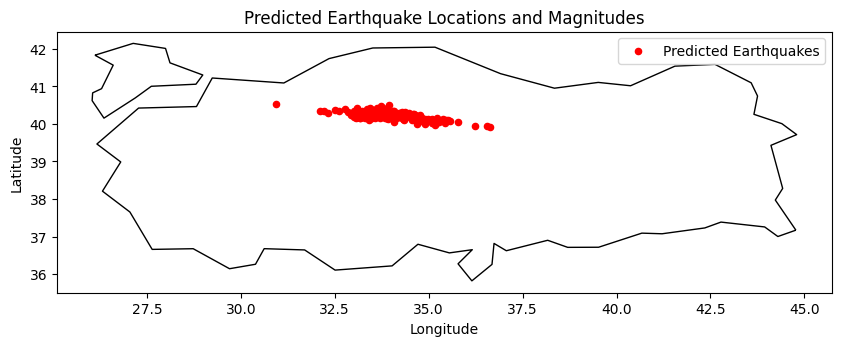

In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load map data for Turkey (or a relevant region)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
turkey = world[world.name == "Turkey"]

# Convert prediction numpy array to GeoDataFrame
# Ensure 'predictions' array is in the format [longitude, latitude, magnitude]
gdf_predictions = gpd.GeoDataFrame(
    predictions,
    columns=['Longitude', 'Latitude', 'Magnitude'],
    geometry=gpd.points_from_xy(predictions[:, 0], predictions[:, 1])
)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
turkey.plot(ax=ax, color='white', edgecolor='black')  # Plot Turkey map
gdf_predictions.plot(ax=ax, markersize=20, color='red', marker='o', label='Predicted Earthquakes')
plt.legend()
plt.title('Predicted Earthquake Locations and Magnitudes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
